In [0]:
# !pip install emoji
import pandas as pd 
# import emoji
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
# Modeling, selection, and evaluation
from fastai.text import *
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from fastai.callbacks import *



# Overview
This notebook explores the possibilities of using the Universal Language Model Fine-tuning (ULMFiT) to apply transfer learning for predicting sentiment of tweets from the Twitter US Airline Sentiment data. The given dataset is really small and hence starting with a pre-trained language model will same time and effort. 
This notebook is divided into the following three sections:

1. **Exploratory Data Analysis:** This part would prove very useful in effectively pre-processing data. 

2. **Data Cleaning/Preprocessing:** Here I have performed some simple tasks such as removing HTML links and accents from the data. This would not follow some traditional procedures such as removing stop-words since the ULMFit language model has been pre-trained on data from Wikipedia. Removing stop-words, in this case, would be highly counter-productive. Also, I have also taken note of some mislabeled and ambiguous data in this step.

3. **Fine-tuning the language model:** I am using the entire dataset including the mislabelled tweets here.

4. **Training the classifier**: I have removed the ambiguous tweets before this step. The model has achieved a maximum accuracy of 85.7.

# EDA
Exploratory data analysis is important to understand important characteristics of the data being dealt with which helps greatly when working on data pre-processing and cleaning.

While exploring this dataset, the following were the most important conclusions drawn:
1. The dataset is unbalanced with respect to target labels/sentiment: There's far more data for negative tweets than for positive or neutral tweets. 
2. The dataset is unbalanced with respect to airlines: We have really less data for tweets addressed to Virgin America. Tweets addressed to United appear most often in our dataset.
3. Low confidence labels: It is to be noted that the data was labelled by hand according to crowdflower. There are many tweets which are labelled with low confidence values(not many people agreed with that label). Those tweets might be ambiguous or too sarcastic for even humans to understand. We need to take a look at this and clean data accordingly.

In [0]:
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [88]:
#loading data
df=pd.read_csv("Tweets.csv")
pd.set_option('display.max_colwidth',0) #so that entire tweets are displayed
#checking the number of rows and columns of the dataset
df.shape

(14640, 15)

Following are the six airlines we have data on:

In [89]:
list(df['airline'].unique())

['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']

The dataset is ordered based on airline name and hence df.head() would print data of only a single airline. Using df.sample() would give a better overview of the dataset.

In [90]:
df.sample(n=5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13298,569894356393570304,negative,1.0,Customer Service Issue,0.6412,American,NaN,phesic86,NaN,0,@AmericanAir I tried already and I am on the waiting list for a call back #2hourwaitsucks,NaN,2015-02-23 08:19:37 -0800,NaN,NaN
10132,569526029859094528,negative,1.0,Customer Service Issue,0.6768,US Airways,NaN,vasisht,NaN,0,@USAirways @AmericanAir my friends are stranded at KPHL and the representatives there won't even give them food vouchers…any help please?,NaN,2015-02-22 07:56:01 -0800,A galaxy far far away,Eastern Time (US & Canada)
1913,569523231524319232,negative,1.0,Customer Service Issue,0.6796,United,NaN,goldsteinmlg,NaN,0,"@united. If you show available seats, you need to honor that! I shouldnt spend 1hr on phone to hear that ""really there are 3 not 4 seats""",NaN,2015-02-22 07:44:54 -0800,NaN,NaN
4725,569898033128693760,neutral,1.0,NaN,NaN,Southwest,NaN,vovoci,NaN,0,@SouthwestAir : thanks.are flights operating now or Cancelled Flightled?,NaN,2015-02-23 08:34:13 -0800,NaN,NaN
1388,569747702981853185,negative,1.0,Cancelled Flight,0.6838,United,NaN,hilary33836700,NaN,0,"@united after 2 days - 1 flight Cancelled Flightled, another delay for 8 hours- united gave me a $7 food voucher. That's how much they value my time??",NaN,2015-02-22 22:36:52 -0800,NaN,NaN


In [0]:
pd.set_option('display.max_colwidth',40) #for a neater display for the next few cells



---



Among the columns, negativereason_gold and airline_sentiment_gold cannot be easily interpreted from their names. 
It seems like negativereason_gold contains negative reasons in case there is a secondary reason for the complaint. Although, mostly both these columns hold the same values. airline_sentiment_gold always contains the same values as airline_sentiment and hence is a duplicate column.






In [92]:
df[~df.negativereason_gold.isnull()].head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,negative,MrEschatologist,Late Flight\nFlight Attendant Compla...,0,@united I'm aware of the flight deta...,NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,negative,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. ...,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,negative,tarlonious,Late Flight,1,@united it's been over 3 hours...at ...,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,negative,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head th...,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,negative,katieclaytonn,Can't Tell,0,@united couldn't have possibly messe...,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)


In [93]:
df[~df.airline_sentiment_gold.isnull()].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,negative,MrEschatologist,Late Flight\nFlight Attendant Compla...,0,@united I'm aware of the flight deta...,NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,negative,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. ...,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2135,569343661063823360,neutral,1.0000,NaN,NaN,United,neutral,aushianya,NaN,0,@united I have a question,NaN,2015-02-21 19:51:21 -0800,NaN,NaN
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,negative,tarlonious,Late Flight,1,@united it's been over 3 hours...at ...,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,negative,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head th...,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)


In [94]:
df[~df.airline_sentiment_gold.isnull()][df.airline_sentiment_gold!=df.airline_sentiment].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone




---


negativereason_gold, airline_sentiment_gold and tweet_coord columns are pretty much empty and hence useless in any analysis. Also they contain mostly redundant information. I will be excluding these columns for further analysis.



In [95]:
df.isnull().sum()*100/df.shape[0]

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64



---



A huge chunk of the data comprises of tweets labelled as negative. This would create a problem in future regarding predicting labels for positive and neutral tweets. Hence, we are bound to have a much better accuracy score for negative labels as compared to positive and neutral irrespective of the method used for classification.

In [96]:
df['airline_sentiment'].value_counts()


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

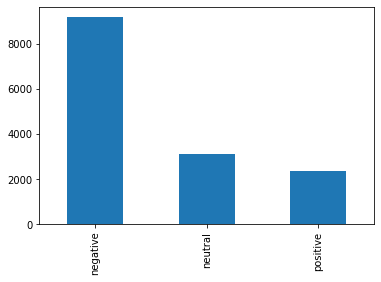

In [97]:
df['airline_sentiment'].value_counts().plot(kind='bar')



---





In the given dataset, the most number of tweets were addressed to United whereas Virgin America appears least often and by a huge margin.
Also, for most airlines, negative tweets are far more than positive or neutral tweets. United, US Airways and American seem to have a much higher ratio of negative tweets.
Hence, in future, we need to keep in mind that our model's analysis should not be influenced by the airline's mention(twitter handle) in the tweet.


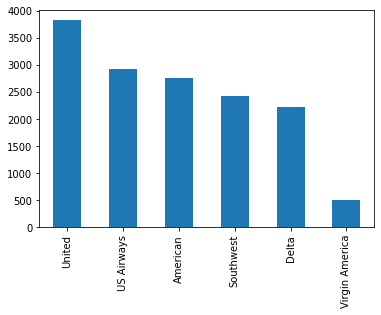

In [98]:
df['airline'].value_counts().plot(kind='bar')

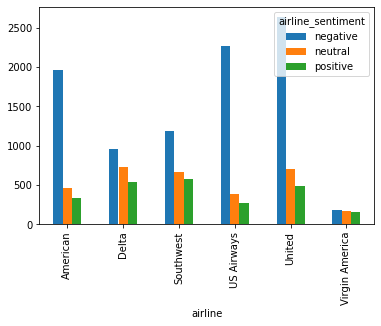

In [99]:
df.groupby(['airline','airline_sentiment']).size().unstack().plot(kind='bar')



---


We have lengthier tweets in case of negative tweets. i.e a higher proportion of negative tweets fall in the range of 120-140 word length. However, the number of tweets also peaks for neutral and positive tweets in the 120-140 word range. Given that we have relatively less data for positive and neutral tweets, it would be wrong to conclude that negative tweets are longer. 

Further analysis by taking random, equal-sized samples of all three labels shows that negative tweets do tend to be longer than neutral and positive tweets.

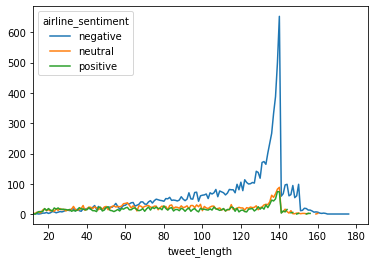

In [100]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot()

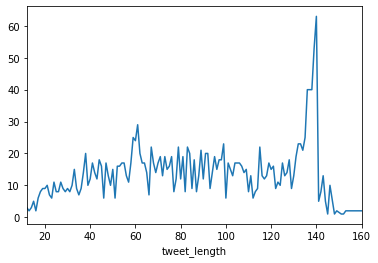

In [101]:
df[df.airline_sentiment=='neutral'].sample(2000).groupby(['tweet_length']).size().plot()

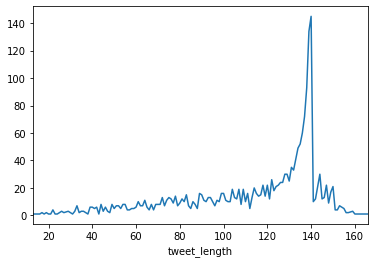

In [102]:
df[df.airline_sentiment=='negative'].sample(2000).groupby(['tweet_length']).size().plot()

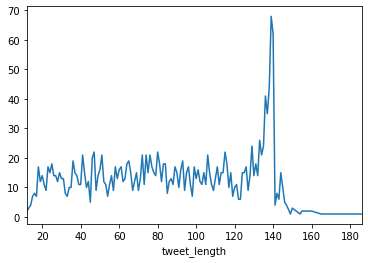

In [103]:
df[df.airline_sentiment=='positive'].sample(2000).groupby(['tweet_length']).size().plot()




---


Tweet length seems to not affect the confidence level of the tweet label. Although from this graph, we can see that neutral and positive tweets have been classified with a slightly lower confidence value, the difference is too small.

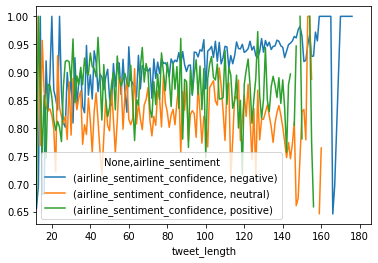

In [104]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)


## Negative reason

The leading cause of complaints are Customer service issues followed by late flights.

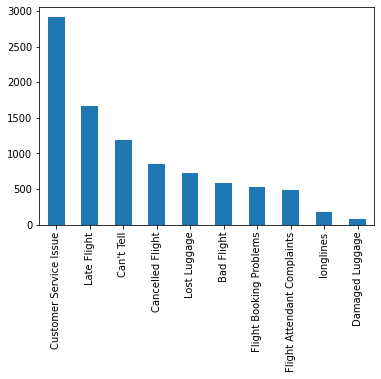

In [105]:
df['negativereason'].value_counts().plot(kind='bar')

Finding the leading causes of complaint for each airline

In [0]:
airlines=list(df['airline'].unique())

In [107]:
airlines

['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']

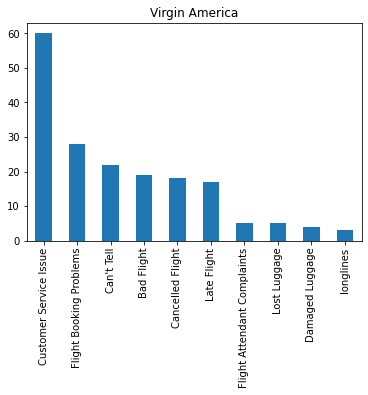

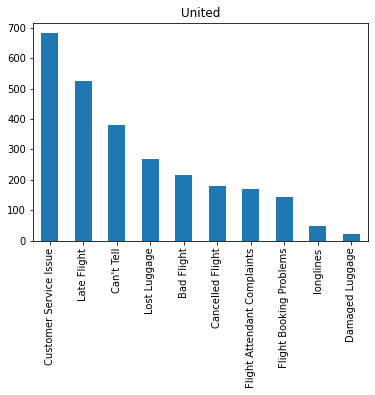

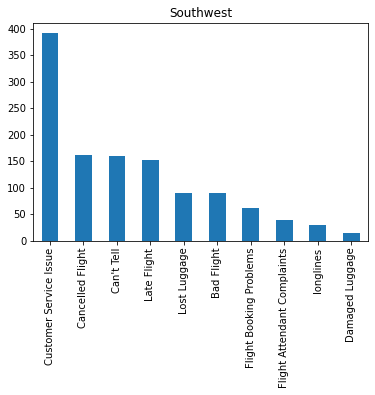

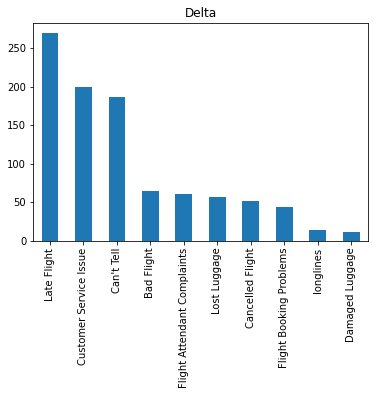

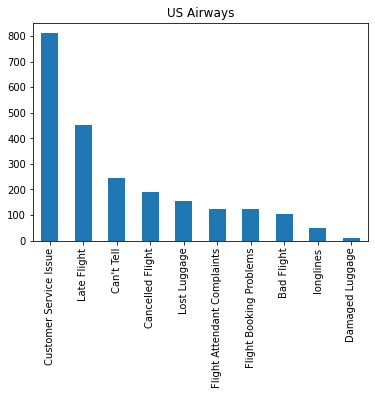

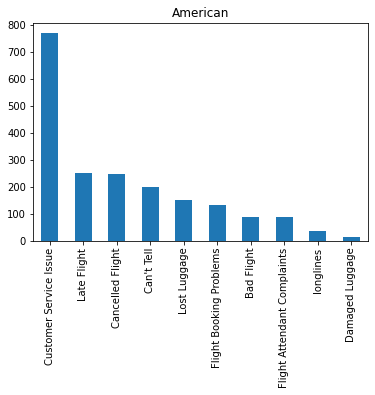

In [108]:
for airline in airlines:
  df[df.airline==airline].negativereason.value_counts().plot(kind='bar',title=airline)
  plt.show()

1. Delta is the only airline receiving the most complaints about a reason other than customer service, i.e. late flights.
2. Overall, the negative reasons statistics follow a similar pattern when it comes to the number of complaints pertaining to each topic.
3. Virgin America got the least complaints regarding late flights.

## Sentiment Confidence

The data being used here was hand-labelled by multiple people and the airline_sentiment_confidence column represents the surety with which the label was allotted.

Overall, most tweets are classified with high confidence. (=1)
The second group of tweets are between 0.6 and 0.8 confidence values and the last group seems to be between 0.3 and 0.4 confidence.

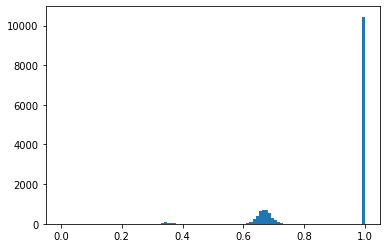

In [109]:
plt.hist(df.airline_sentiment_confidence, bins=np.linspace(0,1,101));


Positive and negative labelled tweets have a higher ratio of low confidence labels as compared to negative tweets. A higher ratio of neutral tweets seems to have been labelled with low confidence. 
I have explored this further in the next section to clean data.

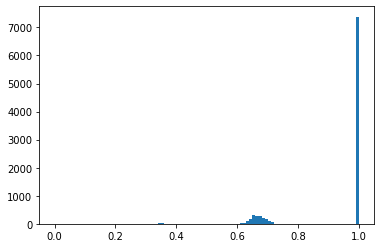

In [110]:
plt.hist(df[df.airline_sentiment=='negative'].airline_sentiment_confidence, bins=np.linspace(0,1,101))
plt.show()


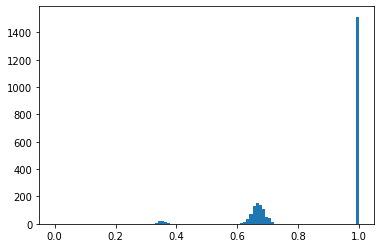

In [111]:
plt.hist(df[df.airline_sentiment=='positive'].airline_sentiment_confidence, bins=np.linspace(0,1,101))
plt.show()


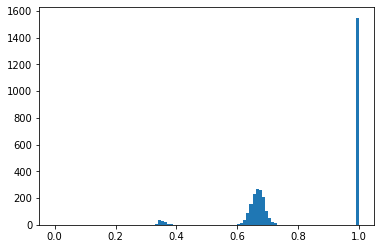

In [112]:
plt.hist(df[df.airline_sentiment=='neutral'].airline_sentiment_confidence, bins=np.linspace(0,1,101))
plt.show()

In [0]:
pd.set_option('display.max_colwidth',0)


# Data Quality Issues/Data Preprocessing

Here, we need to consider the following:

1. The model does not have any context: A tweet's interpretation may completely depend on the context it was written in. The context can be obtained by following a hyperlink included, knowing about a particular event being talked about, following the retweet/reply chain. Unless we implement a method for programmatically obtaining the context, these essentially ambiguous tweets should be excluded from classifier training.

2. Understanding sarcasm is not easy: Often enough, even humans find it difficult to understand sarcasm. Hence, without any explicit negative/positive connotations, the classifier here might not be able to classify sarcasm. 



Let us first consider tweets between 0.2 and 0.4 confidence
From the sample below:
1. The first tweet is clearly mislabeled. Unless there was some context involved, it seems like a negative tweet.
2. Some tweets like the tweet at index 183 cannot even be labelled neutral without having some context. There should either be an "unclear" label for such tweets.
3. Without any context tweet at 309 seems to be a positive tweet.
4. 403 is a sarcastic tweet and seems like a negative opinion.
6. same goes for 509, 508, 679, 875

The conclusion is that many tweets with less than 0.4 confidence are misclassified or unclear. 

In [178]:
df[df.airline_sentiment_confidence<=0.4][['airline_sentiment','text']].head(20)


,airline_sentiment,text
1,positive,@airline plus you've added commercials to the experience... tacky.
114,positive,@airline come back to PHL already. We need you to take us out of this horrible cold. pleasecomeback
142,neutral,@airline Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service
183,positive,RT @airline: Youve met your match. Got status on another airline? Upgrade (+restr):
309,neutral,@airline is saving my sanity right now:
349,negative,@airline It's fine. Already done with my purchase. But you should try it. Just go most of the way through then go back 3
403,neutral,@airline Really? Sprint? I thought you guys were 'kewl'! 0_0
462,neutral,@airline YES FYI MY BFF
488,positive,"@airline so loyal that I'm driving to NYC from PA, to fly Virgin, since you cut Philly flights ;)"
495,negative,@airline my flight (6000) scheduled for 1pm departure still says on time but no plane at gate. Any update on how long of a delay?


Even here, various ambiguous examples can be spotted. In previous iterations, most wrong predictions were due to wrongly labeled tweets. We are not loosing too much data by dropping these but the model does show a higher accuracy especially towards neutral tweets by dropping these.
Hence, I will remove tweets below 0.65 confidence.

In [179]:
df[(df.airline_sentiment_confidence>0.4)|(df.airline_sentiment_confidence<0.65)][['airline_sentiment','text']].head(20)


,airline_sentiment,text
0,neutral,@airline What @dhepburn said.
1,positive,@airline plus you've added commercials to the experience... tacky.
2,neutral,@airline I didn't today... Must mean I need to take another trip!
3,negative,"@airline it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@airline and it's a really big bad thing about it
5,negative,@airline seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA
6,positive,"@airline yes, nearly every time I fly VX this ear worm wont go away :)"
7,neutral,"@airline Really missed a prime opportunity for Men Without Hats parody, there."
8,positive,"@airline Well, I didn'tbut NOW I DO! :-D"
9,positive,"@airline it was amazing, and arrived an hour early. You're too good to me."


Labels above 0.65 confidence seem to be correct mostly.

In [180]:
df[(df.airline_sentiment_confidence>0.65)|(df.airline_sentiment_confidence<0.8)][['airline_sentiment','text']].sample(20)

,airline_sentiment,text
4794,positive,@airline you're my early frontrunner for best airline! oscars2016
10480,negative,@airline how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?
8067,negative,@JetBlue what is going on with your BDL to DCA flights yesterday and today?! Why is every single one getting delayed?
8880,neutral,"@JetBlue do they have to depart from Washington, D.C.??"
8292,negative,@JetBlue I can probably find some of them. Are the ticket s on there?
927,negative,@airline still waiting to hear back. My wallet was stolen from one of your planes so would appreciate a resolution here
3165,negative,@airline Yes my flight was rebooked. I'm just losing trust in you if I want to get anywhere on time.
7894,neutral,@JetBlue Thank you ! What about Paris ? Could we arrange something from there ?
2818,negative,"@airline not 100% sure, however my ticket included one checked bag, therefore this charge was extra and completely unanticipated."
9145,positive,"@airline great crew for flight 504 PHX to YVR tonight! Friendly, efficient. Awesome job."


# Data Preprocessing

Note: I won't be removing the low confidence tweets here. I will use the entire dataset for fine-tuning the language model and then remove the ambiguous tweets before training the classifier.

Without any of the following preprocessing steps, the model only achieves an accuracy of 81 percent. The model also labels exactly the same tweets addressed to different airlines with different labels. i.e., The model was associating airline names with labels as shown in the image below:




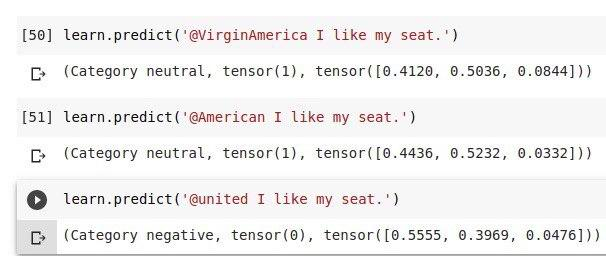

Here, it is to be noted that the pre-trained language model was trained on Wikitext 103 dataset which contains a pre-processed large subset of English Wikipedia. Hence, following popular practices of removing stopwords and changing entire texts to lowercase would lead to a huge loss of information and meaning.

Also, Fast AI provides TextLMDataBunch class to prepare data bunch for text processing. This class takes care of marking unknown words, capitalisation and repetition of words. Which leaves us to perform the following pre-processing steps:

1. Removing non-ASCII characters.
2. Replacing twitter handles of airlines: As discussed above, the model should not associate airline's handles with labels.
3. Removing hyperlinks: While they might provide some context, our model would not be able to make any sense of the links.
4. Removing hashes from hashtags: While the word with the hashtag has meaning, the hashtag does not. 


In [0]:
# function to remove non-ASCII chars from data
def clean_ascii(text):    
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
df['text'] = df['text'].apply(clean_ascii)

In [0]:
#replacing @<airline name> with @airline to avoid wrongly influencing the model
import re
regex = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir)"
def text_replace(text):
    return re.sub(regex, '@airline', text, flags=re.IGNORECASE)



In [0]:
df['text'] = df['text'].apply(text_replace)

In [0]:
#cleaning html tags
from bs4 import BeautifulSoup
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x).get_text())

In [0]:
# this removes entire hashtags
# df_final['text'] = df_final['text'].apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)", " ", x).split()))

#removing only hashes
df['text'] = df['text'].apply(lambda x: ' '.join(re.sub("[#]", " ", x).split()))


In [0]:
#removing hyperlinks
df['text'] = df['text'].apply(lambda x: ' '.join(re.sub("(\w+:\/\/\S+)", " ", x).split()))


# Fine Tuning The Language Model

The data is first divided into a training and validation set. Stratified division is used to make sure data is uniformly distributed.

In [0]:
#selecting required columns
df_final=df[['airline_sentiment','text']]

In [0]:
train, valid = train_test_split(df_final, test_size=0.1,stratify=df.airline_sentiment)

The TextLMDataBunch class adds various tags to denote unknown words, capitalization as well as repetition of words. Words like "don't" have been replaced with "do n't". 
It also removes some HTML tags and processes hashtags that we have taken care of already. I observed that removing the "#" symbol gave better results than just adding a space between the "#" and the tag.

In [194]:
data_lm = TextLMDataBunch.from_df('/temp', train_df = train, valid_df = valid)

In [191]:
data_lm.show_batch()

idx,text
0,"to xxmaj syracuse ? xxmaj after 6 xxmaj cancelled xxmaj flightled flights , one re routing three of us are sitting in xxmaj charlotte xxbos @airline thank you for blowing my vacation . xxmaj could n't get me anywhere today to make my reservation and also lost 2 bags of mine ! xxbos @airline xxup hello ? ! xxmaj it 's been xxup four xxup hours since plane landed !"
1,"another 4 drink coupons xxrep 4 . i think i have over 30 coupons now . free drinks anyone ? xxbos @airline why do i have to wait for 2 hours to talk to someone when you changed my flight ? xxbos @airline @airline xxmaj suggestions , been on hold 2 hrs for flight that is now about to pass departure ... xxmaj dealing w ny weather , need change"
2,me if i 'll make my flight out of here tomorrow 8 am ? i 've been tryin for 3 days now to leave xxbos @airline -- i 've been on hold 40 mins to xxmaj cancelled xxmaj flight my reservation for this afternoon . xxmaj is there another way ? xxmaj web tells me to call . xxbos @airline :( xxmaj thanks for the opportunity ... xxbos @airline @airline
3,! xxmaj yet . xxmaj we ca n't mail xxmaj them a payment and fly before hand right xxbos @airline xxmaj you are 0 for 3 so far in on - time flights on this vacation . xxbos @jetblue i have a disabled seat in row 6 do i get to board earlier ? xxbos @airline xxmaj hey xxunk can you send me to xxmaj atlanta to see @imaginedragons ?
4,"to admirals club for an hour before our flight to our wedding ! xxbos @airline haha , thanks for the explanation xxbos @jetblue xxunk love flying jet blue tho ! ! xxbos 1 / 2 @airline xxmaj just be honest with your customers . xxmaj the new seats are designed to fit more rows on the plane . xxmaj more rows = more money . xxbos @airline xxunk xxmaj another"


## Fine Tuning

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.6, model_dir='/tmp/models')
learn.freeze()


The lr_find function plots the training loss of the learner at different learning rates. It increases the learning after each mini-batch. Eventually, the loss decreases to a minimum at an optimim and then increases steeply as the learning rates become too high.


After the fine-tuning, the model should be able to detect the next word of a tweet with a higher accuracy.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 5.25E-02


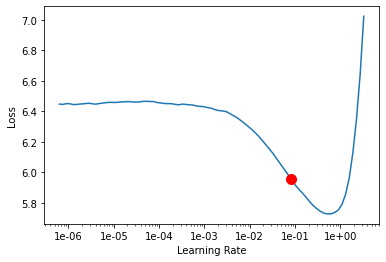

In [193]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

At first, only the last layer of the model is trained. This layer captures more generalised information.

fit_one_cycle takes the maximum learning rate as a parameter for one cycle of learning. According to the ULMfit, slanted triangualar learning rates work best. Hence, the learning rate increases initially and reaches a maximum and then decays slowly.

In [195]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.781593,4.083762,0.252986,00:13


In [0]:
learn.unfreeze()

The model is trained for a few more epochs after unfreezing.

In [197]:
lr  = 1e-2
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.020117,3.773373,0.289927,00:13
1,3.723047,3.651400,0.305608,00:14
2,3.265375,3.662007,0.307087,00:14


The prediction here seems to be grammatically accurate. We now will save the encoder for future use.

In [198]:
learn.predict('I am sitting here', n_words=20)


'I am sitting here in the airport waiting for a flight to Chicago . Any idea when my flight will be'

In [0]:
learn.save_encoder('encoder') #saving the encoder for future use

## Removing low-confidence tweets

As seen before, low confidence tweets are either mis-classified or ambiguous.

In [0]:
dff=df[df.airline_sentiment_confidence>0.65].reset_index(drop=True)

In [201]:
dff.shape

(13651, 16)

Extracting required columns required to train the classifier

In [0]:
df_final_clas=dff[['airline_sentiment','text']]

In [203]:
df_final_clas.shape

(13651, 2)

# Training the Classifier

The data is split into training, test and validation sets. Note that the stratify parameter is extremely important here to make sure that data from all categories is distributed in appropriate ratios among the train, test and validation sets.

In [0]:
train_valid, test = train_test_split(df_final_clas, test_size=0.1,stratify=df_final_clas.airline_sentiment)
train, valid = train_test_split(train_valid, test_size=0.1,stratify=train_valid.airline_sentiment)

Creating the databuch and passing the vocab from the learning model databunch

In [205]:
data_clas = TextClasDataBunch.from_df('/temp',train_df=train, valid_df = valid,test_df = test, vocab=data_lm.train_ds.vocab,  text_cols='text', label_cols='airline_sentiment', bs=32)


The classifier is initialised here with a dropout rate of 0.7. This helps make sure that the model learns fast enough but does not overfit too soon at the same time.

The fine tuned language model saved earler is loaded too.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7, model_dir='/tmp/models')
learn.load_encoder('encoder')
learn.freeze()

Similar to the process followed with the language model, we try to choose a learning rate where the loss is least yet still decreasing. i.e. we do not choose the learning rate at the lowest point of the graph. 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-01
Min loss divided by 10: 5.25E-02


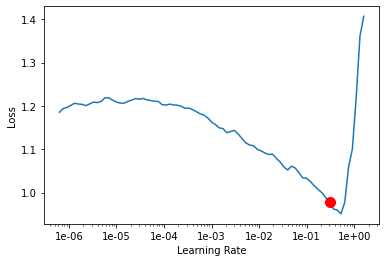

In [207]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


According to the FastAI course, the following values have been found to be the best for momentum and weight decay. The momentum is smaller when we are learning at a higher learning rate and higher when we are learning at a lower learning rate.

The last layer of the model is trained first for a few epochs and the next layers are trained afterwards with lower learning rate for each next layer.

Gradual unfreezing and training is to avoid catastropic forgetting, i.e. loosing all prior information.


In [208]:
moms=(0.8,0.7)
wd=0.1
lr = 1.0E-01
learn.fit_one_cycle(3, lr, moms=moms, wd=wd,callbacks=[SaveModelCallback(learn, name="best_lm")])

epoch,train_loss,valid_loss,accuracy,time
0,0.752653,1.119232,0.397071,00:14
1,0.708799,0.584495,0.812856,00:13
2,0.611348,0.503721,0.814483,00:15


Better model found at epoch 0 with valid_loss value: 1.1192317008972168.
Better model found at epoch 1 with valid_loss value: 0.5844947695732117.
Better model found at epoch 2 with valid_loss value: 0.5037214756011963.


In [209]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd,callbacks=[SaveModelCallback(learn, name="best_lm")])

epoch,train_loss,valid_loss,accuracy,time
0,0.665708,0.526471,0.819365,00:14
1,0.557943,0.431438,0.842962,00:15
2,0.492568,0.406126,0.855167,00:14


Better model found at epoch 0 with valid_loss value: 0.5264706015586853.
Better model found at epoch 1 with valid_loss value: 0.4314376413822174.
Better model found at epoch 2 with valid_loss value: 0.4061256945133209.


In [210]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd,callbacks=[SaveModelCallback(learn, name="best_lm1")])

epoch,train_loss,valid_loss,accuracy,time
0,0.563459,0.425907,0.831570,00:16
1,0.516571,0.418956,0.847844,00:15
2,0.396473,0.372588,0.859235,00:15


Better model found at epoch 0 with valid_loss value: 0.42590704560279846.
Better model found at epoch 1 with valid_loss value: 0.4189563989639282.
Better model found at epoch 2 with valid_loss value: 0.37258774042129517.


In [0]:
learn.unfreeze()

In [212]:
lr /= 5
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd,callbacks=[SaveModelCallback(learn, name="best_lm")])

epoch,train_loss,valid_loss,accuracy,time
0,0.356071,0.368027,0.856794,00:16
1,0.314385,0.371326,0.860862,00:17
2,0.318010,0.378095,0.863303,00:16


Better model found at epoch 0 with valid_loss value: 0.36802688241004944.


In [213]:
learn.predict('@united I love my seat.')

(Category positive, tensor(2), tensor([0.0390, 0.2015, 0.7595]))

Without clearing mis-labeled or ambiguous tweets, the sentence below was being labeled as negative.

In [214]:
learn.predict('my seat is here')

(Category neutral, tensor(1), tensor([0.3003, 0.6643, 0.0354]))

In [215]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.857


Text(0.5, 1.0, 'Classifation Confusion Matrix')

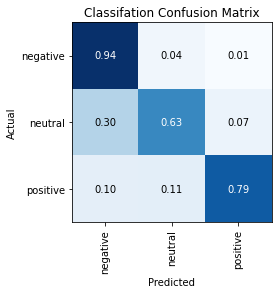

In [216]:
interp.plot_confusion_matrix(normalize=True)
plt.title('Classifation Confusion Matrix')

In [217]:
interp.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
"xxbos @airline @robertdwyer xxup aa does nt charge any fees to change award tickets as long as the origin , destination & award type remains the same",neutral,positive,6.39,0.00
xxbos @airline the flight is n't that empty xxrep 4 . xxmaj is this rude or not ?,negative,neutral,5.10,0.01
xxbos @airline i might look into that . xxmaj my wife travels much more than i do . xxmaj could we both use the membership ?,neutral,positive,4.91,0.01
xxbos @airline xxmaj lisa j is amazing the guy not so much .,positive,neutral,4.90,0.01
"xxbos @airline xxmaj believe me , i understand . xxmaj flight 2955 . xxmaj was originally booked for xxmaj sunday . xxmaj flight was xxmaj cancelled xxmaj flighted and rescheduled for today .",negative,positive,4.84,0.01
"xxbos @airline i 'm flying with your competitor today , starts with an u and ends with xxup xxunk i will never make that mistake again . xxunk",negative,positive,4.81,0.01
xxbos @airline my xxup tsa precheck is n't showing up on my boarding pass for my flight tomorrow ... help ! ? usairways tsaprecheck,negative,neutral,4.58,0.01
xxbos @airline thanks . xxmaj bummer . xxmaj poor planning on my part . i assume the card in xxmaj passbook wo n't work either ?,negative,neutral,4.32,0.01
"xxbos @jetblue many thanks , as always your employees are professional and courteous . xxmaj whenever i have the option , you are my go - to airlines .",positive,neutral,4.15,0.02
"xxbos @airline i have such a love hate relationship with you . xxmaj some days you 're good , the others you are so terribly awful its xxunk",negative,neutral,4.02,0.02


**From the sample above most tweets seem to have been predicted accurately and the actual label seems to be wrong.**

From my perspective, the model only got the 5th, 6th and 8th wrong.

## Conclusion and possible improvements

1. The model is able to reach an overall accuracy of 85.7 percent. 
2. The classifier's performance is the lowest for neutral tweets with only 0.64 percent correct labels. For positive labels, this goes up to 0.79.
3. The data still seems to have some mis-labelled tweets which is further lowering the visible performance of the model.
4. The model could be improved by including more data for positive and neutral tweets. In a practical scenario, I would have spent some time to relabel the wrongly labeled neutral and positive tweets since they were only a few hundred. That might have helped improve the model further. 
5. Tweets addressing two airlines with contrasting opinions for both could have been excluded from the dataset since they cannot be associated with a single label.
6. As suggested in the ULMfit paper, a backwards language model and using an ensemble of a forward and a backward classifier might yeild better results. However, When I tried it with this problem, I did not see any significant improvement in the results. However, people who have artificially generated tweets for positive and neutral labels to create a balanced dataset seem to see an improvement in the classifier's accuracy.